# Baseline Models

In [18]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

In [19]:
f= h5py.File('Data1.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

In [20]:
print('image',image.shape)
print('cat',cat.shape)
print('label',label.shape)
print('snr',snr.shape)
print('sigma',sigma.shape)
print('image_nonoise',image_nonoise.shape)
print('image_withnoise',image_withnoise.shape)

image (18779, 64, 64)
cat (18779, 6, 64, 64)
label (18779, 5)
snr (18779,)
sigma (18779,)
image_nonoise (18779, 64, 64)
image_withnoise (18779, 64, 64)


In [21]:
get_elip1 = lambda g1,g2 : - (1+g1**2+g2**2-2*np.sqrt(g1**2+g2**2))/(-1+g1**2+g2**2)
get_theta = lambda g1,g2 : np.arctan2(-g1,-g2)

Some helper functions functions to convert g1 and g2 to elliptity and theta.

In [22]:
f=0.9 #use a 90% train test split. 
all_inds = np.linspace(0,len(label)-1,len(label)).astype(int)
train_inds = np.random.randint(0,len(label)-1,int(len(label)*f))
test_inds = np.setdiff1d(all_inds,train_inds)

In [109]:
train_nonoise = image_nonoise[train_inds]
test_nonoise = image_nonoise[test_inds]
train_noise = image_withnoise[train_inds]
test_noise = image_withnoise[test_inds]
train_label = label[train_inds]
test_label = label[test_inds]
train_snr = snr[train_inds]
test_snr = snr[test_inds]

In [24]:
train_flux = train_label[:,0]
test_flux = test_label[:,0]
train_index = train_label[:,1]
test_index = test_label[:,1]
train_rad = train_label[:,2]
test_rad = test_label[:,2]
train_g1 = train_label[:,3]
test_g1 = test_label[:,3]
train_g2 = train_label[:,4]
test_g2 = test_label[:,4]
train_ellip = get_elip1(train_g1,train_g2)
test_ellip = get_elip1(test_g1,test_g2)
train_theta = get_theta(train_g1,train_g2)
test_theta = get_theta(test_g1,test_g2)

In [25]:
len(train_index)
len(test_index)

7654

## Flux Model : Aperature Photometry

Text(0.5, 1.0, 'Centre')

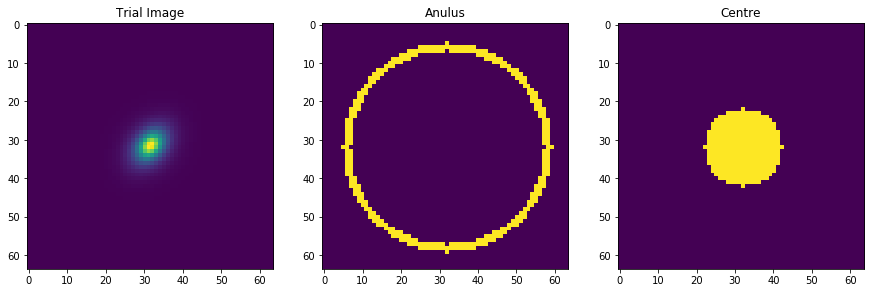

In [26]:
def getanulus(r2,r3):
    y,x = np.ogrid[-32:64-32, -32:64-32]
    mask2 = x**2 + y**2 <= r2**2
    mask3 = x**2 + y**2 <= r3**2
    array = np.zeros((64, 64)) 
    array[mask3] = 1
    array[mask2] = 0
    return array

def getcentre(r1):
    y,x = np.ogrid[-32:64-32, -32:64-32]
    mask1 = x**2 + y**2 <= r1**2
    array = np.zeros((64, 64)) 
    array[mask1] = 1
    return array

#defining aperature sizes
r1,r2,r3= 10,25,27
anulus = getanulus(r2,r3)
centre = getcentre(r1)

fig, ax = plt.subplots(ncols=3,figsize=(15,5))

ax[0].imshow(train_nonoise[0])
ax[0].set_title("Trial Image")
ax[1].imshow(anulus)
ax[1].set_title("Anulus")
ax[2].imshow(centre)
ax[2].set_title("Centre")

for the flux model we use aperature photometry. Here we take the center to be large enough to capture most of the light of the galaxy and the anulus to be an area far away from the galaxy. We sum up the flux through all the pixels in the anulus and divide by the number of images in the anulus to get the sky-brightness per pixel. We then subtract the flux in the center by this value * the number of pixels in the centre. We then assume the flux is given by some linear function of the resulting sum. (In reality we could determine this function by properly understanding our instrument and/or using a guide star. Nevertheless, we expect the intercept of this function to be relatively small since we got rid of the sky brightness). 

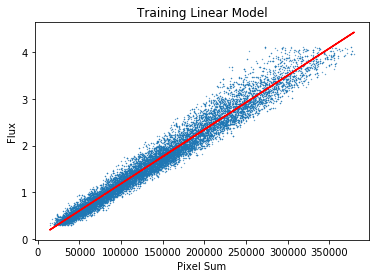

In [27]:
#train on noisy data, this is a highly vectorized aperature photometry scheme. Runs fast!
sky_per_pixel = np.sum((train_noise*anulus),(1,2))/(np.sum(anulus))
tots = np.sum((train_noise*centre),(1,2)) - np.sum(centre)*sky_per_pixel

model = np.polyfit(tots,train_flux,1)
plt.scatter(tots,train_flux,s=0.1)
plt.plot(tots,np.polyval(model,tots),c='r')
plt.title("Training Linear Model")
plt.xlabel("Pixel Sum")
plt.ylabel("Flux")

#make predictions
sky_per_pixel = np.sum((test_noise*anulus),(1,2))/(np.sum(anulus))
tots = np.sum((test_noise*centre),(1,2)) - np.sum(centre)*sky_per_pixel
pred_flux = np.polyval(model,tots)

The linear model looks good, small intercept! Next is a plot of the predictions on the test set.

(0, 4.5)

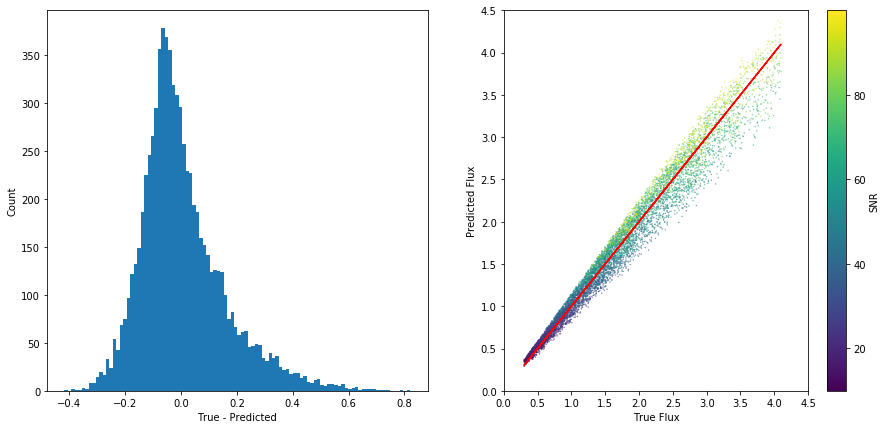

In [28]:
fig,ax = plt.subplots(ncols=2,figsize=(15,7))
sc = ax[1].scatter(test_flux,pred_flux,s=0.1,c=test_snr)
flux_err = test_flux - pred_flux
plt.colorbar(sc,label='SNR')

ax[0].hist(flux_err,bins=100)
ax[0].set_xlabel("True - Predicted")
ax[0].set_ylabel("Count")

ax[1].plot(test_flux,test_flux,c='r')
ax[1].set_xlabel("True Flux")
ax[1].set_ylabel("Predicted Flux")
ax[1].set_xlim(0,4.5)
ax[1].set_ylim(0,4.5)

## Sersic Radius & Index Model

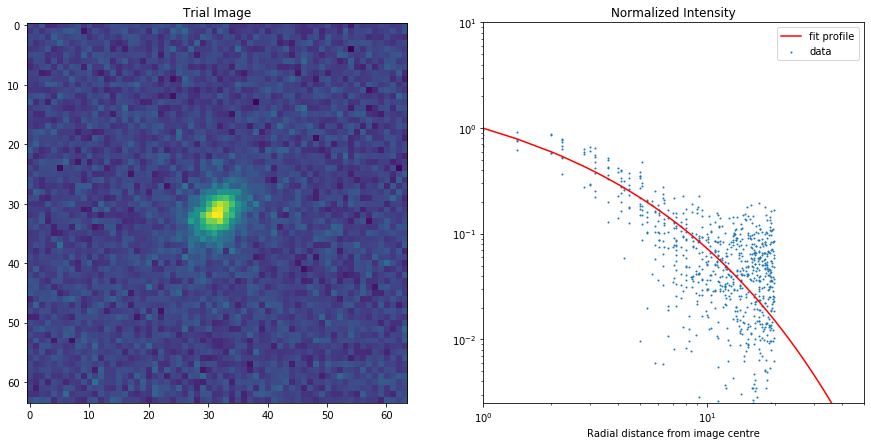

In [38]:
#some helper functions
b = lambda n: (2*n-1)/3
def func(r,Ie,n,Re):
    fac = (r/Re)**(1/n)
    return Ie*np.e**(-b(n)*(fac-1))

#example code
img = train_noise[0]
xgrid = np.linspace(0,63,64)
X,Y = np.meshgrid(xgrid,xgrid)
rs = np.sqrt((X-32)**2 + (Y-32)**2).flatten()

args = np.argsort(rs)
rs = rs[args]
vals = img.flatten()[args]
#normalize to avoid bad behavior
nvals = vals/np.max(vals)
#only choose r up to 20 pixels away so we avoid fitting too much noise, exclude where r=0. 
inds = np.where((rs<20)& (rs>0) & (nvals>0))
popt, pcov = curve_fit(func, rs[inds], nvals[inds],maxfev=10000)

fig,ax = plt.subplots(ncols=2,figsize=(15,7))
ax[0].imshow(img)
ax[0].set_title("Trial Image")
ax[1].scatter(rs[inds],nvals[inds],s=1,label='data')
ax[1].plot(rs,func(rs,*popt),c='r',label='fit profile')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(2.5e-3,1e1)
ax[1].set_xlim(1e0,5e1)
ax[1].set_title("Trial Fit")
ax[1].set_xlabel("Radial distance from image centre")
ax[1].set_title("Normalized Intensity")
ax[1].legend()
plt.show()

For the sersic model we simpliy fit a sersic profile to the galaxy assuming its at the centre of the image. We normalize the image before hand and write our profile in terms of the half light radius, the intensity and the index. We fit data only at positive non-zero r < 20.  This is to avoid fitting too much noise - which causes a slowdown in our fitting routine. (Note we expect this approach to be problematic especially with highly oblate galaxies - should we have intended this to be a more complicated model it would've been good to take into account ellipticity of the galaxies, but this is fine for a naieve baseline). We have bounded our fits informed by our EDA, again to help with speed. 

In [81]:
def get_sersic(img):
    xgrid = np.linspace(0,63,64)
    X,Y = np.meshgrid(xgrid,xgrid)
    rs = np.sqrt((X-32)**2 + (Y-32)**2).flatten()
    vals = img.flatten()
    nvals = vals/np.max(vals)
    #remember to remove the one point where r=0
    inds = np.where((rs<20)& (rs>0) & (nvals>0))
    bounds = [[0,0,0],[2,6,0.7]]
    popt, pcov = curve_fit(func, rs[inds], nvals[inds],bounds=bounds)
    return popt[1:]

#Since this is a direct fit, we don't need the train set in this case
out = []
for i in range(len(test_noise)):
    out.append(get_sersic(test_noise[i]))
out = np.asarray(out)
pred_index = out.T[0]
pred_rad = out.T[1]

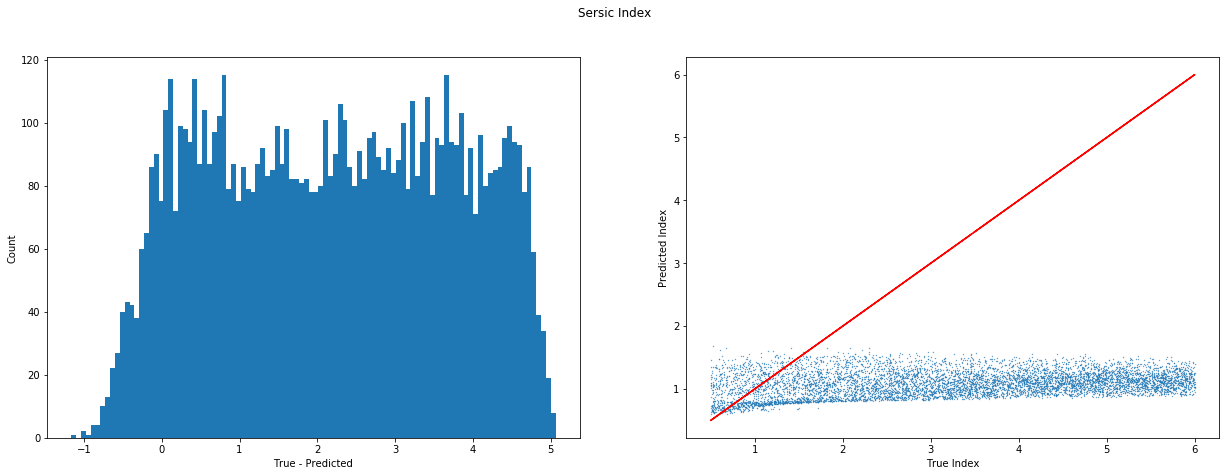

In [122]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
index_err = test_index-pred_index
ax[0].hist(index_err,bins=100)
ax[0].set_xlabel("True - Predicted")
ax[0].set_ylabel("Count")

ax[1].scatter(test_index,pred_index,s=0.1)
ax[1].set_ylabel("Predicted Index")
ax[1].set_xlabel("True Index")
ax[1].plot(test_index,test_index,c='r')
plt.suptitle("Sersic Index")
plt.show()

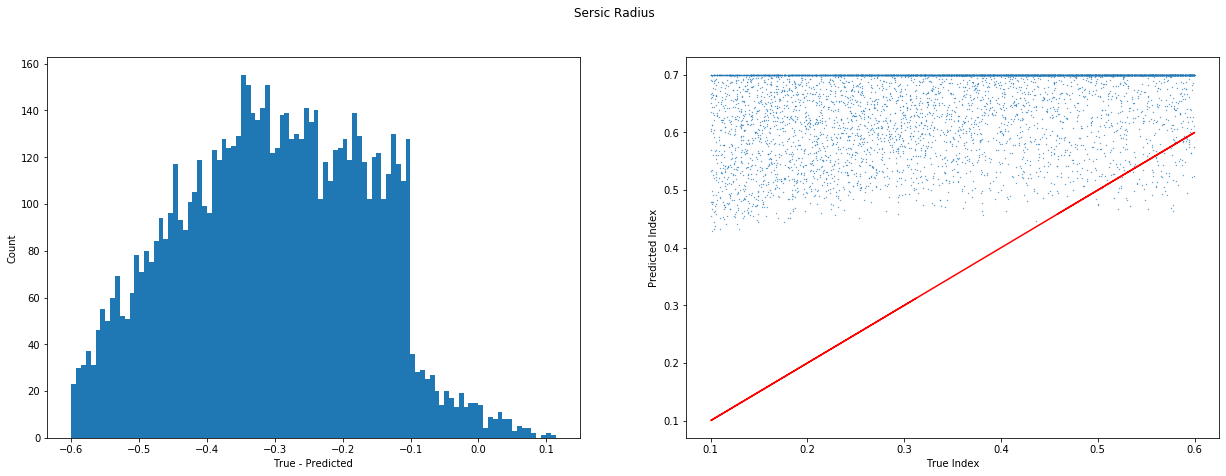

In [123]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
rad_err = test_rad-pred_rad
ax[0].hist(rad_err,bins=100)
ax[0].set_xlabel("True - Predicted")
ax[0].set_ylabel("Count")

rad_model = np.polyfit(test_rad,pred_rad,2)
ax[1].scatter(test_rad,pred_rad,s=0.1)
ax[1].set_ylabel("Predicted Index")
ax[1].set_xlabel("True Index")
ax[1].plot(test_rad,test_rad,c='r')
plt.suptitle("Sersic Radius")
plt.show()

As expected, this model has little predictive power, predicting essentially a constant for both the Sersic Radius and Index. In this case we simply use the results from directly fitting the train data. In principle we could make a linear model based on the train data, but if the prediction is constant - or nearly so, it won't improve the predictions. 

## g1 and g2 model

In [84]:
#modified from stackoverflow: 
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

def twoD_Gaussian2(coords, sigma_x, sigma_y, theta):
    #Setting a bunch of parameters, speeds up the fitting!
    xo=31.5
    yo=31.5
    offset=0.0
    amplitude=1.0
    (x, y) = coords
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian(nimg):
    img = nimg/np.max(nimg)

    x = np.linspace(0, 63, 64)
    y = np.linspace(0, 63, 64)
    x, y = np.meshgrid(x, y)
    #first three parameters are set, the others I guess at the middle of their intervals
    initial_guess = (3.5,3.5,np.pi/2)
    bounds = [[0,0,0],[7,7,np.pi]]
    popt, pcov = curve_fit(twoD_Gaussian2, (x, y), img.flatten(), p0=initial_guess,bounds=bounds)
    data_fitted = twoD_Gaussian2((x, y), *popt)

    sigx = popt[0]
    sigy = popt[1]
    theta = popt[2]
    #minor over major axis
    guess_elip = np.min([sigx,sigy])/np.max([sigx,sigy])
    return theta,guess_elip

To estimate g1 and g2 our plan is to fit a gaussian to the image, derive the ellipticity and orientation to the fit and use these to derive g1 and g2. First lets look at rotations of our gaussian:

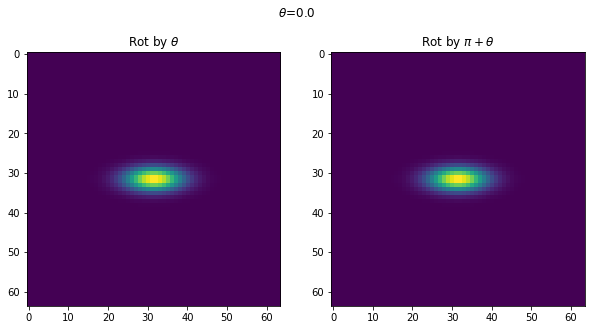

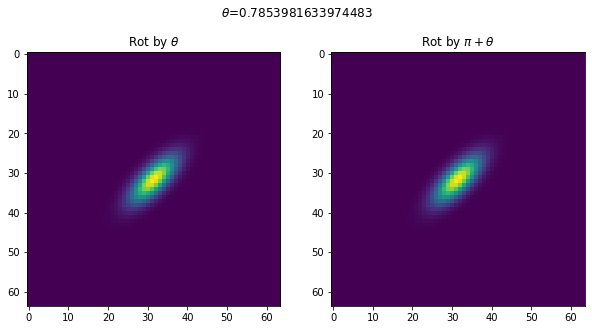

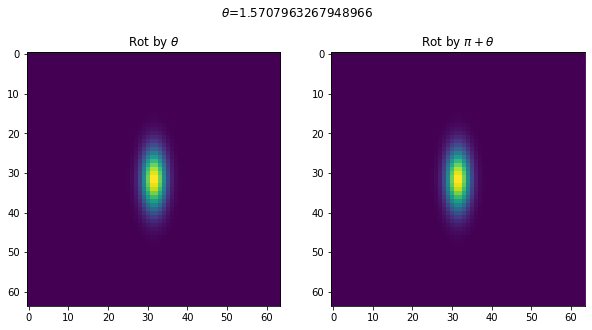

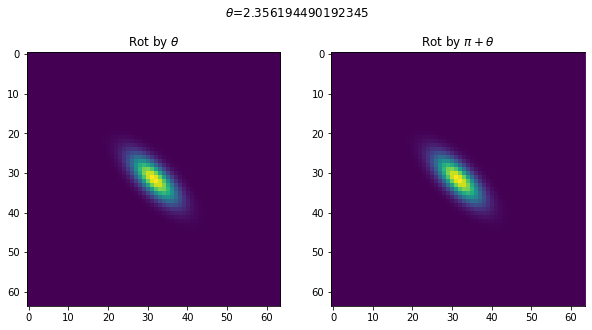

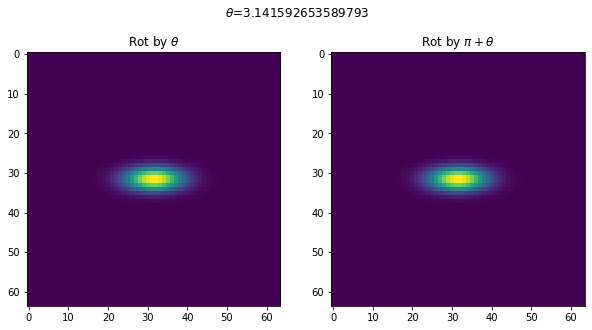

In [43]:
x = np.linspace(0, 63, 64)
y = np.linspace(0, 63, 64)
x, y = np.meshgrid(x, y)

thetas = np.linspace(0,np.pi,5)
for theta in thetas:
    fig,ax = plt.subplots(ncols=2,figsize=(10,5))
    data_fitted = twoD_Gaussian2((x, y), 5,2,theta)
    ax[0].imshow(data_fitted.reshape(64, 64))
    ax[0].set_title(r"Rot by $\theta$")
    data_fitted = twoD_Gaussian2((x, y), 5,2,np.pi+theta)
    ax[1].imshow(data_fitted.reshape(64, 64))
    ax[1].set_title(r"Rot by $\pi + \theta$")
    plt.suptitle(r'$\theta$='+str(theta))
    plt.show()

Note that since the gaussian is perfectly symmetric, rotations by $\pi$ look just like rotations by $2\pi$. This will come into play later.  For now we'll fit normalized images to reduce the parameter space we must explore. This will help with speed. 

[ 2.26698544  3.09380169 -0.70743745]


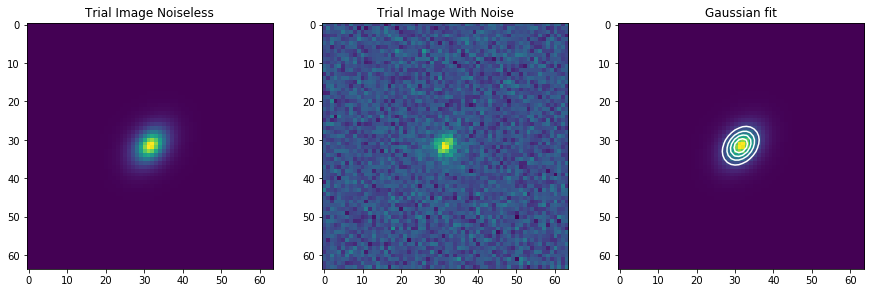

In [87]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))

img = train_nonoise[0]/np.max(train_nonoise[0])
x = np.linspace(0, 63, 64)
y = np.linspace(0, 63, 64)
x, y = np.meshgrid(x, y)
#first three parameters are set, the others I guess at 0
initial_guess = (3.5,3.5,np.pi/2)
bounds = [[0,0,-np.pi],[7,7,np.pi]]
popt, pcov = curve_fit(twoD_Gaussian2, (x, y), img.flatten(), p0=initial_guess,bounds=bounds)
data_fitted = twoD_Gaussian2((x, y), *popt)

ax[0].imshow(img)
ax[0].set_title("Trial Image Noiseless")
ax[1].imshow(train_noise[5])
ax[1].set_title("Trial Image With Noise")
ax[2].imshow(img)
ax[2].contour(x, y, data_fitted.reshape(64, 64), 4, colors='w')
ax[2].set_title("Gaussian fit")
print(popt)

In [88]:
#fit to train
out = []
for i in range(len(train_noise)):
    out.append(fit_gaussian(train_noise[i]))
out = np.asarray(out)
pred_thetas = out.T[0]
pred_ellips = out.T[1]
model = np.polyfit(pred_ellips,train_ellip,3)
pred2_ellips = np.polyval(model,pred_ellips)
pred2_thetas = 2*np.mod(pred_thetas-np.pi/4,np.pi/2)

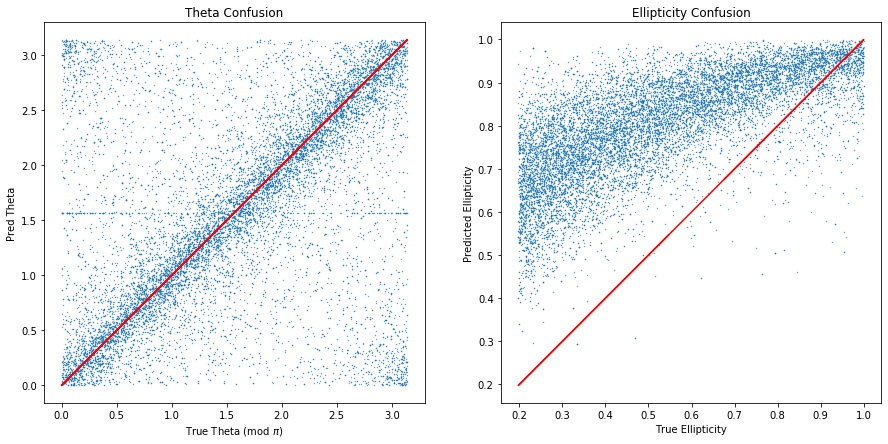

In [102]:
fig,ax = plt.subplots(ncols=2,figsize=(15,7))
ax[0].scatter(np.mod(train_theta,np.pi),pred2_thetas,s=0.1)
ax[0].plot(np.mod(train_theta,np.pi),np.mod(train_theta,np.pi),c='r')
ax[0].set_xlabel(r"True Theta (mod $\pi$)")
ax[0].set_ylabel(r"Pred Theta")
ax[0].set_title(r"Theta Confusion")

plt.scatter(train_ellip,pred_ellips,s=0.1)
plt.plot(train_ellip,train_ellip,c='r')
ax[1].set_xlabel(r"True Ellipticity")
ax[1].set_ylabel(r"Predicted Ellipticity")
ax[1].set_title(r"Ellipticity Confusion")
plt.show()

Here's the predicitions on the training data we do very well with the $\theta$ parameter (we have to mod this $2\pi$ since my symmetric gaussian model can't distinguish between positive and negative angles. We do well with the magnitude though!). For the ellipticity we don't do very well, but unlike the sersic parameters there's actually some information there. We'll incorporate a linear fit into our model, which should improve it slightly. 

In [110]:
#predict on test
out = []
for i in range(len(test_noise)):
    out.append(fit_gaussian(test_noise[i]))
out = np.asarray(out)
pred_thetas = out.T[0]
pred_ellips = out.T[1]
pred2_ellips = np.polyval(model,pred_ellips)
pred2_thetas = 2*np.mod(pred_thetas-np.pi/4,np.pi/2)
pred_g1 = ((1-pred2_ellips)/(1+pred2_ellips))*np.sin(pred2_thetas)
pred_g2 = np.abs(((1-pred2_ellips)/(1+pred2_ellips))*np.cos(pred2_thetas))

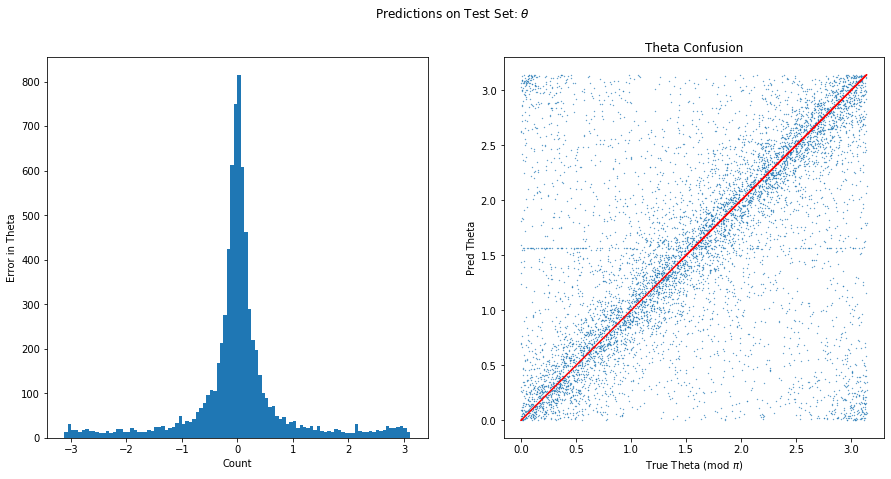

In [113]:
pred2_thetas = 2*np.mod(pred_thetas-np.pi/4,np.pi/2)

fig,ax = plt.subplots(ncols=2,figsize=(15,7))
theta_err = np.mod(test_theta,np.pi)-pred2_thetas
ax[0].hist(theta_err,bins=100)
ax[0].set_xlabel(r"Count")
ax[0].set_ylabel(r"Error in Theta")
ax[1].scatter(np.mod(test_theta,np.pi),pred2_thetas,s=0.1)
ax[1].plot(np.mod(test_theta,np.pi),np.mod(test_theta,np.pi),c='r')
ax[1].set_xlabel(r"True Theta (mod $\pi$)")
ax[1].set_ylabel(r"Pred Theta")
ax[1].set_title(r"Theta Confusion")
plt.suptitle(r"Predictions on Test Set: $\theta$")
plt.show()

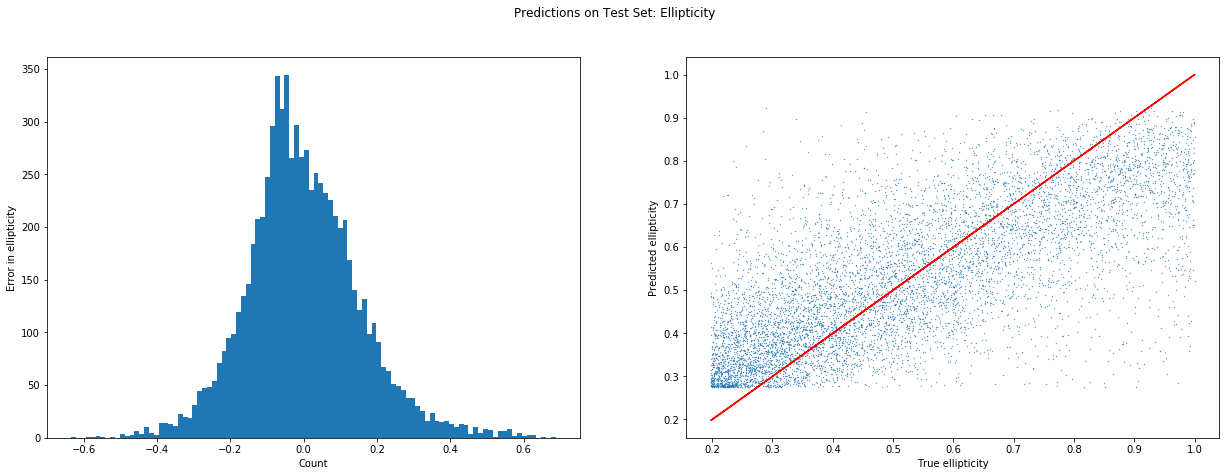

In [116]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
ellip_err = test_ellip-pred2_ellips
ax[0].set_xlabel(r"Count")
ax[0].set_ylabel(r"Error in ellipticity")

ax[0].hist(ellip_err,bins=100)
ax[1].scatter(test_ellip,pred2_ellips,s=0.1)
ax[1].set_xlabel("True ellipticity")
ax[1].set_ylabel("Predicted ellipticity")
ax[1].plot(test_ellip,test_ellip,c='r')
plt.suptitle(r"Predictions on Test Set: Ellipticity")
plt.show()

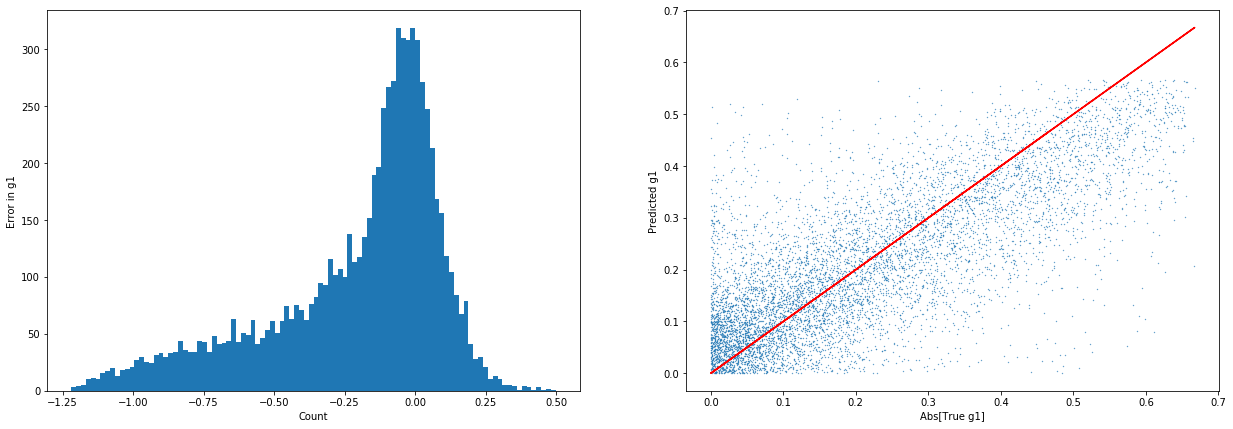

In [117]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
g1_err = test_g1-pred_g1
ax[0].hist(g1_err,bins=100)
ax[0].set_xlabel(r"Count")
ax[0].set_ylabel(r"Error in g1")

ax[1].scatter(np.abs(test_g1),pred_g1,s=0.1)
ax[1].set_ylabel("Predicted g1")
ax[1].set_xlabel("Abs[True g1]")

ax[1].plot(np.abs(test_g1),np.abs(test_g1),c='r')

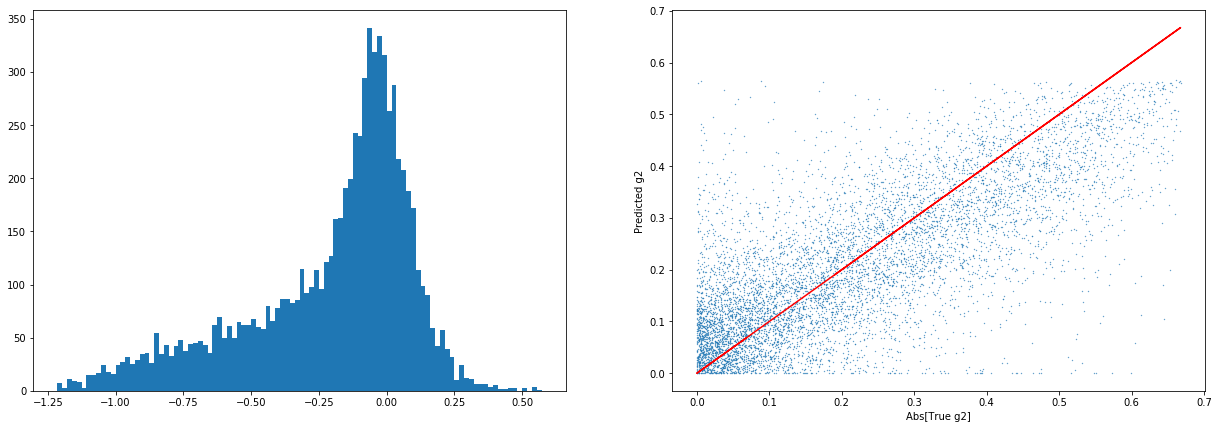

In [118]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
g2_err = test_g2-pred_g2
ax[0].hist(g2_err,bins=100)

ax[1].scatter(np.abs(test_g2),pred_g2,s=0.1)
ax[1].set_ylabel("Predicted g2")
ax[1].set_xlabel("Abs[True g2]")

ax[1].plot(np.abs(test_g2),np.abs(test_g2),c='r')

Now we can look at the predictions on the test set. In general I do fairly well, but theres a long spread. There's also the caveat that I can only do predictions on the magnitude of the g1 and g2 values. 

In [67]:
pred_label = np.asarray([pred_flux,pred_index,pred_rad,pred_g1,pred_g2]).T
np.save('test_params.npy',test_label.astype(float))
np.save('pred_params.npy',pred_label.astype(float))
np.save('snr.npy',test_snr.astype(float))

Just outputing arrays to file

## Summary

To be thorough, lets make a confusion matrix of all our predctions and their depdencies!

In [152]:
errors = np.asarray([flux_err,index_err,rad_err,g1_err,g2_err,theta_err,ellip_err])
true_vals = np.asarray([test_flux,test_index,test_rad,test_g1,test_g2,test_theta,test_ellip,test_snr])
errorlabels = ['Flux Error','Index Error','Radius Error','g1 Error','g2 Error','Theta Error','Ellipticity Error']
truthlabels = ['True Flux','True Index','True Radius','np.abs(True g1)','np.abs(True g2)','True Theta','True Ellipticity','True SNR']

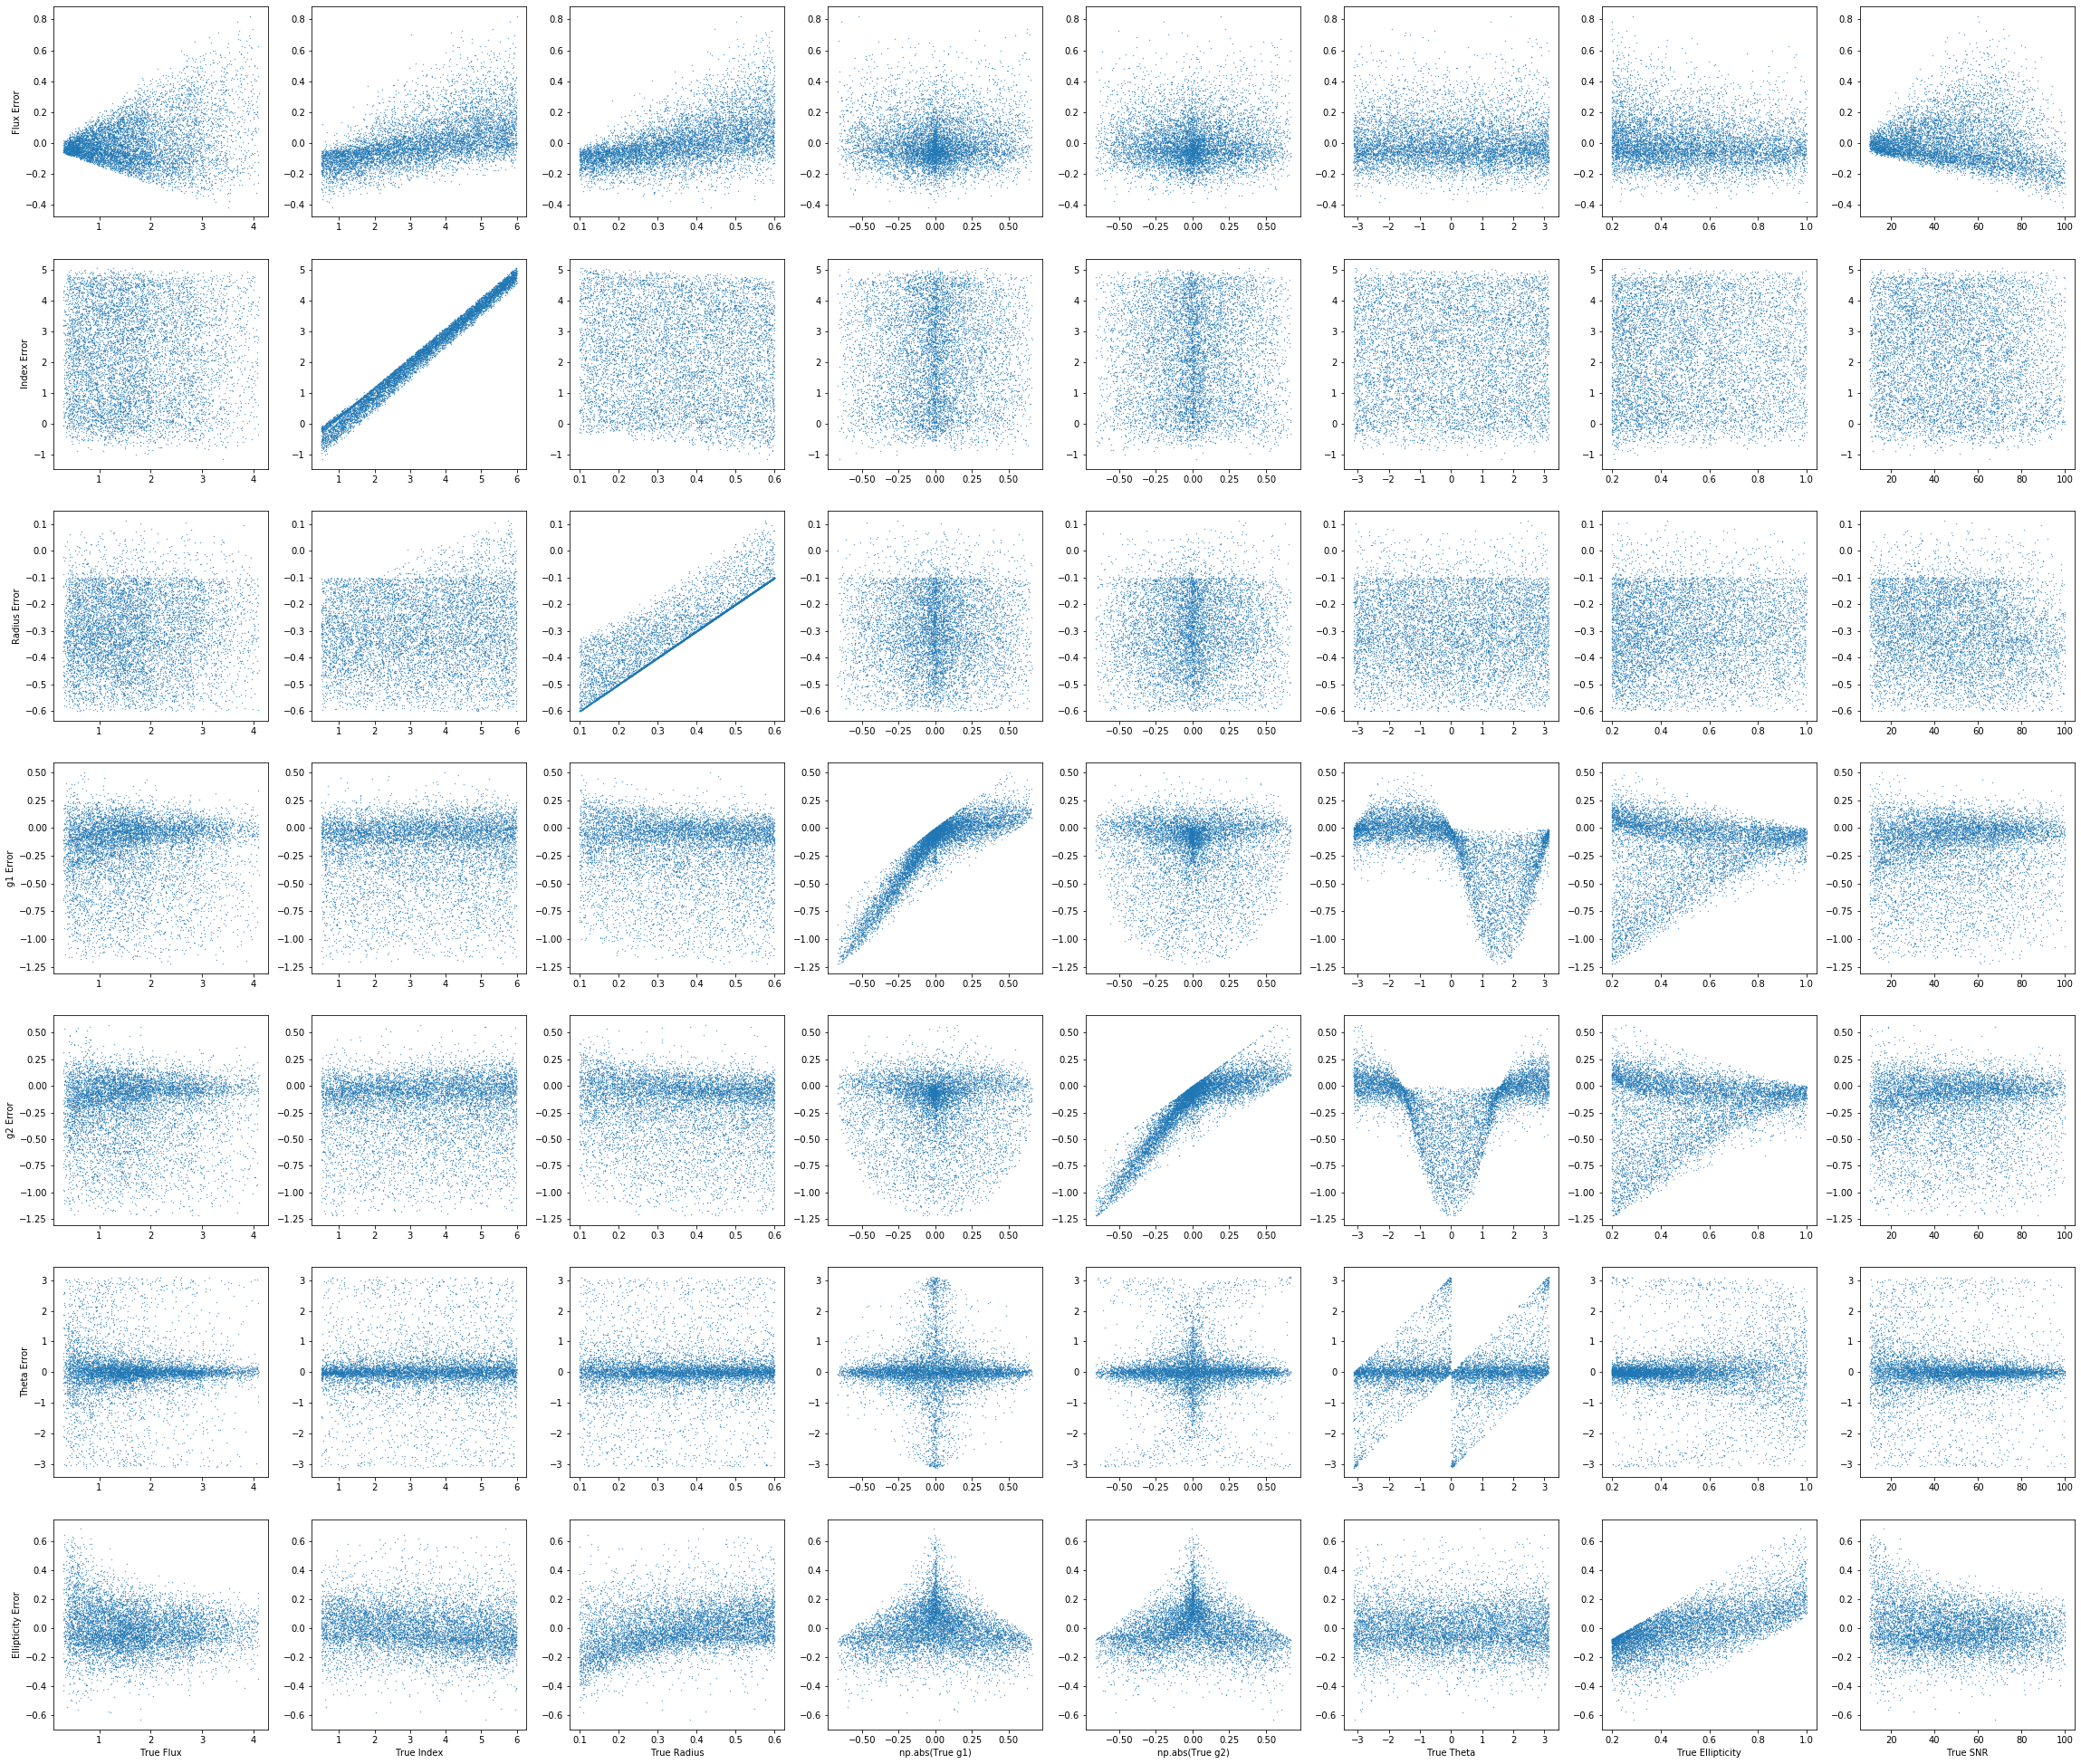

In [153]:
fig,ax = plt.subplots(ncols=len(true_vals),nrows=len(errors),figsize=(40,35))
for i in range(len(true_vals)):
    for j in range(len(errors)):
        ax[j,i].scatter(true_vals[i],errors[j],s=0.1)
        
for i in range(len(true_vals)):
    ax[-1,i].set_xlabel(truthlabels[i])
    
for j in range(len(errorlabels)):
    ax[j,0].set_ylabel(errorlabels[j])

There's a lot of interesting things we can note here:

1. The absolute error in flux becomes larger as the flux increases and we are biased to lower flux levels at extremely high signal to noise. Large sersic radii and indexes bias in the opposite direction. This is rather surprising (one might expect brighter sources to be easier to characterize), but it's important to keep in mind we're fitting absolute error - it's likely the fractional error in the flux decreases with increasing flux. 

2. The error in the sersic index is larger for larger sersic indexes (perhaps a larger sersic index is a more gradual change and is harder to pick up on?). Dosen't seem to depend much on anythin else

3. The error in sersic radius depends on the sersic radius, but more loosely than the index. It always seems underestimated. 

4. The erorr in g1 and g2 both care very much on g1 and g2, extreme values (especially negative ones) cause underestimates. This is dominated by errors in fitting extremely elliptical galaxies. Theres's also an interesting correlation with theta, but that's likely geometric. 

5. The error in theta seems independ of all other parameters (except g1,g2 and theta which are geomemtrically connected). 

6. The error in fitting elipticity is much larger at low fluxes and low signal to noise levels (which makes sense!). There are also geometric correlations with g1 and g2 - as expected.